# Algorithme par gradient de Politique

Dans ce TP, l'objectif est d'implémenter l'algorithme REINFORCE basé sur le gradient de la politique pour trouver une politique optimale pour l'environnement [CartPole](https://gymnasium.farama.org/environments/classic_control/cart_pole/).


In [72]:
import gymnasium as gym
import random
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import utils
%matplotlib inline
%load_ext autoreload

def init_seed(seedval):
    torch.manual_seed(seedval)
    np.random.seed(seedval)
    random.seed(seedval)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1 Définition de la Politique

L'algorithme REINFORCE utilise des politiques stochastiques, ainsi que la log probabilité des actions prises dans chaque état. Pour cela, les [distributions PyTorch](https://pytorch.org/docs/stable/distributions.html) sont à utiliser.



In [73]:
class Politique(nn.Module):
    def __init__(self, dim_entree:int, dim_sortie:int , dim_cachee:int):
        super(Politique, self).__init__()
        self.f1 = nn.Linear(dim_entree,dim_cachee)
        self.f2 = nn.Linear(dim_cachee,dim_sortie)
        self.relu = nn.ReLU()

    def forward(self, etat : np.ndarray):
        etat = torch.tensor(etat, dtype=torch.float)
        x = self.f1(etat)
        x = self.relu(x)
        x = self.f2(x)
        x = F.softmax(x, dim=1)
        return x

        
    def action(self, etat : np.ndarray) -> tuple[int,torch.Tensor]:
        """
        Renvoi l'action a executer dans etat et la log proba de cette action
        """
        if isinstance(etat, np.ndarray):
            etat = torch.tensor(etat, dtype=torch.float).unsqueeze(0) 
            probabilites = self.forward(etat)
            distribution = torch.distributions.Categorical(probabilites)
            action = distribution.sample()
            log_proba = distribution.log_prob(action)
            
        return action, log_proba
            
        
    
    

# 2 Algorithme REINFORCE


In [74]:

def trajectoire(env,politique, max_t:int =500)->  tuple[list,list]:
    """
        max_t: nombre max de pas de la trajectoire
    """
    etat, _ = env.reset(seed=random.randint(0,5000))
    liste_reward = []
    liste_log_proba = []
    for i in range(max_t):
        action,log_proba = politique.action(etat)
        action = action.item()
        next_state,reward,done, _ , _ = env.step(action)
        liste_reward.append(reward)
        liste_log_proba.append(log_proba)
        if done :
            break
        etat=next_state
    return liste_reward,liste_log_proba
        



In [75]:
env = gym.make("CartPole-v1")
init_seed(5)
state_dim = env.observation_space.shape[0] 
action_dim = env.action_space.n
dim_cache = 64
politique = Politique(state_dim,action_dim,64)

for i in range(10):
    liste_reward, liste_log_proba = trajectoire(env, politique)
    somme_reward = sum(liste_reward)
    print(f"somme des récompenses {i+1} = {somme_reward}")

env.close()


somme des récompenses 1 = 52.0
somme des récompenses 2 = 27.0
somme des récompenses 3 = 12.0
somme des récompenses 4 = 14.0
somme des récompenses 5 = 24.0
somme des récompenses 6 = 14.0
somme des récompenses 7 = 19.0
somme des récompenses 8 = 14.0
somme des récompenses 9 = 14.0
somme des récompenses 10 = 14.0


C:\Users\DELL\AppData\Local\Temp\ipykernel_13032\604695970.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  etat = torch.tensor(etat, dtype=torch.float)


# 3 REINFORCE avec m=1 (1 trajectoire par rollout)

La méthode *loss_reinforce* ci-dessous calcule à partir des informations sur une trajectoire $\tau = (s_0,a_0,r_0,s_1, ...,s_{H+1})$ :
$$\sum_{t=0}^H log \pi_\theta(a_t | s_t) R(\tau)$$
avec le retour cumulé total sur la trajectoire:
$$R(\tau) = \sum_{t=0}^H \gamma^t r_t$$



In [76]:
def loss_reinforce(log_probs:list, retour_cumule:float):
    """
        log_probs: liste des log proba des actions prises à chaque pas d'une trajectoire 
        retour_cumule : somme pondérée des recompenses obtenue sur une trajectoire
        renvoi: loss = - sum_t logproba(a_t) * retour_cumule
    """
    loss = []
    for log_prob in log_probs: 
        loss.append(-log_prob * retour_cumule) 
    return torch.cat(loss).sum()

def reinforce(env,politique, nb_episodes=2000, gamma=0.99, max_t=500) -> list:

    optimizer = optim.Adam(politique.parameters(), lr=1e-3)
    etat, _ = env.reset(seed=random.randint(0,5000))
    total_rewards = []
    for epoch in range(nb_episodes):
        liste_reward, liste_log_proba = trajectoire(env, politique,max_t)
        Somme_reward_cumule=0
        for t,reward in enumerate(liste_reward) :
            reward_cumule = (gamma**t)*reward
            Somme_reward_cumule += reward_cumule
            
        loss=loss_reinforce(liste_log_proba,Somme_reward_cumule)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

        total_rewards.append(sum(liste_reward))
    
        if (epoch+1) % 50 == 0 :          
            print(f"Épisode {epoch + 1}/{nb_episodes}, Somme des 100 derniers épisodes: {sum(total_rewards[-50:])}")
             
    return total_rewards
        

C:\Users\DELL\AppData\Local\Temp\ipykernel_13032\604695970.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  etat = torch.tensor(etat, dtype=torch.float)


Épisode 50/2000, Somme des 100 derniers épisodes: 1048.0
Épisode 100/2000, Somme des 100 derniers épisodes: 1192.0
Épisode 150/2000, Somme des 100 derniers épisodes: 1316.0
Épisode 200/2000, Somme des 100 derniers épisodes: 1404.0
Épisode 250/2000, Somme des 100 derniers épisodes: 1582.0
Épisode 300/2000, Somme des 100 derniers épisodes: 1504.0
Épisode 350/2000, Somme des 100 derniers épisodes: 1866.0
Épisode 400/2000, Somme des 100 derniers épisodes: 2343.0
Épisode 450/2000, Somme des 100 derniers épisodes: 2228.0
Épisode 500/2000, Somme des 100 derniers épisodes: 2374.0
Épisode 550/2000, Somme des 100 derniers épisodes: 3113.0
Épisode 600/2000, Somme des 100 derniers épisodes: 3329.0
Épisode 650/2000, Somme des 100 derniers épisodes: 4148.0
Épisode 700/2000, Somme des 100 derniers épisodes: 3908.0
Épisode 750/2000, Somme des 100 derniers épisodes: 3738.0
Épisode 800/2000, Somme des 100 derniers épisodes: 4123.0
Épisode 850/2000, Somme des 100 derniers épisodes: 3893.0
Épisode 900/200

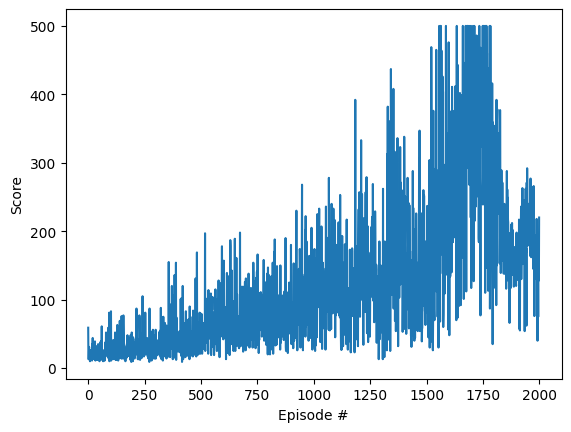

In [77]:
env = gym.make("CartPole-v1")
init_seed(5)
state_dim = env.observation_space.shape[0] 
action_dim = env.action_space.n
dim_cache = 64
politique = Politique(state_dim,action_dim,64)
total_rewards = reinforce(env,politique)
utils.plot_sumrwdperepi(total_rewards)

# 4 REINFORCE avec reward-to-go

Une action prise à l'instant $t$ impacte uniquement les récompenses obtenues à partir de $t$, et pas les récompenses passées. 

Pour améliorer l'algorithme précédent, on peut calculer la $loss$ en considérant à chaque action la somme pondérée des récompenses obtenues sur la trajectoire à partir de cette action (retour cumulé à chaque pas)

La méthode *loss_reinforce2* calcule à partir des informations sur une trajectoire  $\tau = (s_0,a_0,r_0,s_1, ...,s_{H+1})$ :
$$\sum_t log \pi_\theta(a_t | s_t) R_t(\tau)$$
avec le retour cumulé au pas $t$:
$$R_t(\tau) = \sum_{k=t}^H \gamma^{k-t} r_k$$


In [65]:
def loss_reinforce2(log_probs:list, retours_cumules:list):
    """
        log_probs: liste des log proba des actions prises à chaque pas d'une trajectoire 
        retours_cumules : liste des retours cumulés à chaque pas de la trajectoire
        renvoi: loss = - sum_t logproba(a_t) * retour_cumule_t
    """
    loss = []
    for log_prob,r_cumul in zip(log_probs,retours_cumules): 
        loss.append(-log_prob * r_cumul) 
    return torch.cat(loss).sum()


def retours_cumules(recompenses : list, gamma: float =0.99):
    """
       recompenses: liste des récompenses reçues à chaque pas de la trajectoire
       renvoi: retour cumulé à chaque pas de la trajectoire
    """
    total_retours_cumules=[]
    H = len(recompenses)
    for t in range(H):
        Somme_reward_cumule = 0
        for k in range(t,H) :
            reward_cumule = (gamma**(k-t))*recompenses[k]
            Somme_reward_cumule += reward_cumule
        total_retours_cumules.append(Somme_reward_cumule)
            
    return total_retours_cumules
    




In [78]:
def reinforce2(env,politique, nb_episodes=2000, gamma=0.99,  max_t=500) -> list:
    
    optimizer = optim.Adam(politique.parameters(), lr=1e-3)
    etat, _ = env.reset(seed=random.randint(0,5000))
    total_rewards = []
    for epoch in range(nb_episodes):
        liste_reward, liste_log_proba = trajectoire(env, politique,max_t)
        retourscumules = retours_cumules(liste_reward,gamma)
        loss=loss_reinforce2(liste_log_proba,retourscumules)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_rewards.append(sum(liste_reward))
    
        if (epoch+1) % 50 == 0 :          
            print(f"Épisode {epoch + 1}/{nb_episodes}, Somme des 100 derniers épisodes: {sum(total_rewards[-50:])}")
    
            
    return total_rewards
     



C:\Users\DELL\AppData\Local\Temp\ipykernel_13032\604695970.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  etat = torch.tensor(etat, dtype=torch.float)


Épisode 50/2000, Somme des 100 derniers épisodes: 1243.0
Épisode 100/2000, Somme des 100 derniers épisodes: 1405.0
Épisode 150/2000, Somme des 100 derniers épisodes: 1935.0
Épisode 200/2000, Somme des 100 derniers épisodes: 2536.0
Épisode 250/2000, Somme des 100 derniers épisodes: 2783.0
Épisode 300/2000, Somme des 100 derniers épisodes: 5555.0
Épisode 350/2000, Somme des 100 derniers épisodes: 8069.0


C:\Users\DELL\AppData\Local\Temp\ipykernel_13032\604695970.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  etat = torch.tensor(etat, dtype=torch.float)


Épisode 400/2000, Somme des 100 derniers épisodes: 10117.0
Épisode 450/2000, Somme des 100 derniers épisodes: 12564.0
Épisode 500/2000, Somme des 100 derniers épisodes: 15368.0
Épisode 550/2000, Somme des 100 derniers épisodes: 15744.0
Épisode 600/2000, Somme des 100 derniers épisodes: 19068.0
Épisode 650/2000, Somme des 100 derniers épisodes: 15469.0
Épisode 700/2000, Somme des 100 derniers épisodes: 17310.0
Épisode 750/2000, Somme des 100 derniers épisodes: 20982.0
Épisode 800/2000, Somme des 100 derniers épisodes: 23334.0
Épisode 850/2000, Somme des 100 derniers épisodes: 21937.0
Épisode 900/2000, Somme des 100 derniers épisodes: 19999.0
Épisode 950/2000, Somme des 100 derniers épisodes: 14843.0
Épisode 1000/2000, Somme des 100 derniers épisodes: 19360.0
Épisode 1050/2000, Somme des 100 derniers épisodes: 23193.0
Épisode 1100/2000, Somme des 100 derniers épisodes: 22710.0
Épisode 1150/2000, Somme des 100 derniers épisodes: 23842.0
Épisode 1200/2000, Somme des 100 derniers épisodes: 

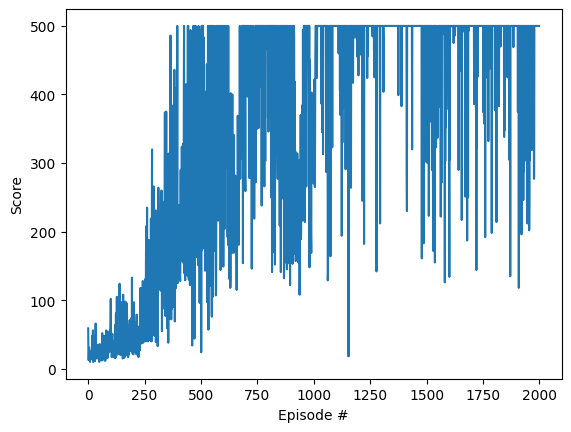

In [79]:
env = gym.make("CartPole-v1")
init_seed(5)
state_dim = env.observation_space.shape[0] 
action_dim = env.action_space.n
dim_cache = 64
politique = Politique(state_dim,action_dim,64)
total_rewards = reinforce2(env,politique)
utils.plot_sumrwdperepi(total_rewards)